## Statistical Analysis

Now that we are able to predict the sentiment of each aspect given the review, we can perform various statistical anaylsis to porvide valuable insigts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.utils import shuffle
import seaborn as sns
import os

#### 1. Chi squared tests

Assuming df1 is your restaurant and df2 is the competitor 

Chi-squared test for Food#Taste: chi2 = 3.0433, p-value = 0.3850


/tmp/ipykernel_50381/1999027743.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[aspect] = preprocess_labels(df1, aspect)
/tmp/ipykernel_50381/1999027743.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[aspect] = preprocess_labels(df2, aspect)


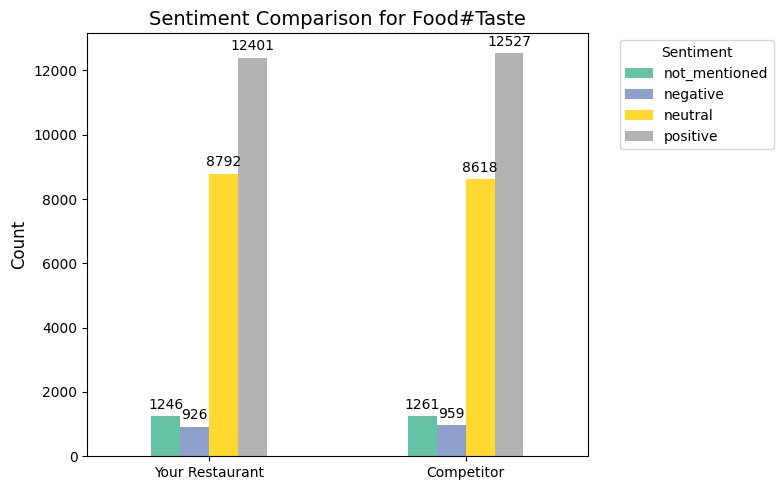

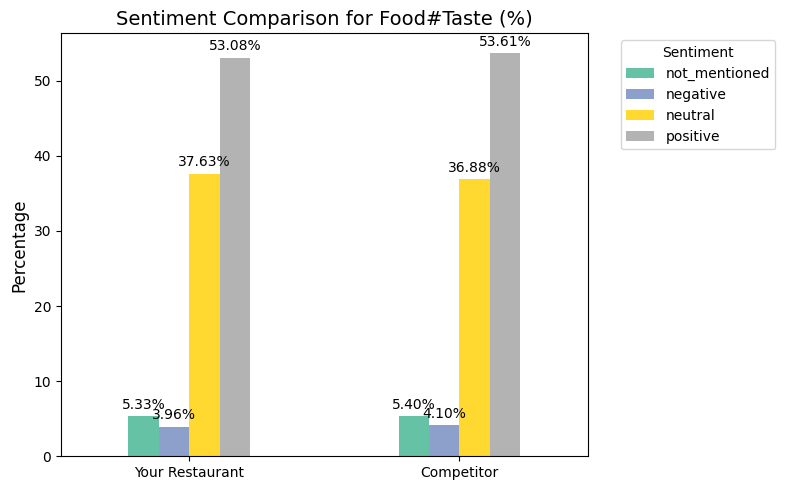

In [ ]:
RANDOM_SEED = 21231

# Create output directory for plots
OUTPUT_DIR = "eda_plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define sentiment categories and colors (from EDA code)
SENTIMENTS = ["not_mentioned", "negative", "neutral", "positive"]
SENTIMENT_COLORS = {
    "not_mentioned": "#808080",  # Gray
    "negative": "#FF0000",  # Red
    "neutral": "#1F77B4",  # Blue
    "positive": "#2CA02C",  # Green
}

# Load and combine datasets
try:
    dev = pd.read_csv("data/dev.csv")
    test = pd.read_csv("data/test.csv")
    train = pd.read_csv("data/train.csv")
except FileNotFoundError as e:
    print(
        f"Error: {e}. Ensure 'data/dev.csv', 'data/test.csv', and 'data/train.csv' exist."
    )
    exit(1)

# Combine and shuffle
combined_df = pd.concat([dev, test, train], ignore_index=True)
combined_df = shuffle(combined_df, random_state=RANDOM_SEED)

# Split into two datasets (simulating Your Restaurant and Competitor)
df1 = combined_df[: len(combined_df) // 2]  # Your Restaurant
df2 = combined_df[len(combined_df) // 2 :]  # Competitor

# Define aspect
aspect = "Food#Taste"


# Preprocess labels (convert -2, -1, 0, 1 to sentiment labels)
def preprocess_labels(df, aspect):
    label_map = {-2: "not_mentioned", -1: "negative", 0: "neutral", 1: "positive"}
    if aspect not in df.columns:
        print(f"Error: Aspect '{aspect}' not found in dataset.")
        exit(1)
    return df[aspect].map(label_map)


# Apply preprocessing
df1[aspect] = preprocess_labels(df1, aspect)
df2[aspect] = preprocess_labels(df2, aspect)

# Check for valid data
if df1[aspect].isna().any() or df2[aspect].isna().any():
    print(f"Warning: Missing values found in {aspect}. Dropping NaNs.")
    df1 = df1.dropna(subset=[aspect])
    df2 = df2.dropna(subset=[aspect])

# Compute sentiment counts
your_counts = df1[aspect].value_counts().reindex(SENTIMENTS, fill_value=0)
comp_counts = df2[aspect].value_counts().reindex(SENTIMENTS, fill_value=0)

# Create contingency table
contingency_table = pd.DataFrame(
    [your_counts, comp_counts], index=["Your Restaurant", "Competitor"]
)

# Perform chi-squared test
try:
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-squared test for {aspect}: chi2 = {chi2:.4f}, p-value = {p:.4f}")
except ValueError as e:
    print(f"Chi-squared test failed: {e}")
    p = None

# Plot with counts (raw counts)
plt.figure(figsize=(8, 5))
ax = contingency_table.plot(
    kind="bar",
    width=0.45,
    color=[SENTIMENT_COLORS[sent] for sent in SENTIMENTS],
    ax=plt.gca(),
)
plt.title(f"Sentiment Comparison for {aspect}", fontsize=14)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(
    labels=SENTIMENTS, title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.tight_layout()

# Add counts on top of each bar
for i, bar_group in enumerate(ax.patches):
    height = bar_group.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.annotate(
            f"{int(height)}",
            xy=(bar_group.get_x() + bar_group.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.savefig(
    os.path.join(OUTPUT_DIR, f"sentiment_comparison_{aspect}_counts.png"),
    bbox_inches="tight",
)
plt.close()

# Plot with percentages (normalized)
contingency_table_normalized = (
    contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
)
plt.figure(figsize=(8, 5))
ax = contingency_table_normalized.plot(
    kind="bar",
    width=0.45,
    color=[SENTIMENT_COLORS[sent] for sent in SENTIMENTS],
    ax=plt.gca(),
)
plt.title(f"Sentiment Comparison for {aspect} (%)", fontsize=14)
plt.ylabel("Percentage", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(
    labels=SENTIMENTS, title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.tight_layout()

# Add percentages on top of each bar
for i, bar_group in enumerate(ax.patches):
    height = bar_group.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.annotate(
            f"{height:.2f}%",
            xy=(bar_group.get_x() + bar_group.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.savefig(
    os.path.join(OUTPUT_DIR, f"sentiment_comparison_{aspect}_percentage.png"),
    bbox_inches="tight",
)
plt.close()

#### 2. ANOVA

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: predictions_df with a "date" column
predictions_df["date"] = pd.to_datetime(...)  # Load or parse dates
predictions_df["month"] = predictions_df["date"].dt.to_period("M")

# Calculate monthly positive sentiment proportion
aspect = "Service#Hospitality"
monthly_sentiment = (
    predictions_df.groupby("month")[aspect]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
monthly_positive = monthly_sentiment["positive"] * 100

# Plot
monthly_positive.plot(figsize=(10, 5))
plt.title(f"Positive Sentiment Trend for {aspect} (%)")
plt.ylabel("Positive Sentiment (%)")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

#### 3. Aspect correlation

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert sentiments to numeric for correlation
sentiment_scores = predictions_df.replace(
    {"not_mentioned": 0, "negative": -1, "neutral": 0, "positive": 1}
)

# Compute correlation matrix
corr_matrix = sentiment_scores.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Sentiment Correlation Across Aspects")
plt.tight_layout()
plt.show()

#### 4. Word cloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example: Extract negative reviews for an aspect
aspect = "Service#Queue"
negative_reviews = predictions_df[predictions_df[aspect] == "negative"]["review"]

# Generate word cloud
text = " ".join(negative_reviews)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud for Negative {aspect} Reviews")
plt.show()

#### 5. Statistical Significance Testing for Aspect Improvements

In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

# Example: before_df and after_df with sentiment predictions
aspect = "Food#Taste"
before_counts = before_df[aspect].value_counts()
after_counts = after_df[aspect].value_counts()
contingency_table = pd.DataFrame(
    [before_counts, after_counts], index=["Before", "After"]
)

# Chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table.fillna(0))
print(f"Chi-squared test for {aspect}: p-value = {p:.4f}")

# Visualize
contingency_table.plot(kind="bar", figsize=(8, 5))
plt.title(f"Sentiment Change for {aspect}")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.show()